<ipython-input-1-df9aad4cf876>:62: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:308.)
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
<ipython-input-1-df9aad4cf876>:66: ComplexWarning: Casting complex values to real discards the imaginary part
  y0_exact = torch.tensor([  A * np.exp(1j * k1 * x) + B * np.exp(-1j * k1 * x)], dtype=torch.float32)
<ipython-input-1-df9aad4cf876>:67: ComplexWarning: Casting complex values to real discards the imaginary part
  dy_dx0_exact = torch.tensor([ A * 1j * k1 * np.exp(1j * k1 * x) - B * 1j * k1 *  np.exp(-1j * k1 * x)  ], dtype=torch.float32)
<ipython-input-1-df9aad4cf876>:70: ComplexWarning: Casting complex values to real discards the imaginary part
  yL_exact = torch.tensor([ A + B ], dtype=torch.float32)                # contorno x = L (observe que tanto faz usar psi1(x) ou ps2(x) em x= L = 0
<ipython-input-1-df9aad4cf876>:98: ComplexWarning: Castin

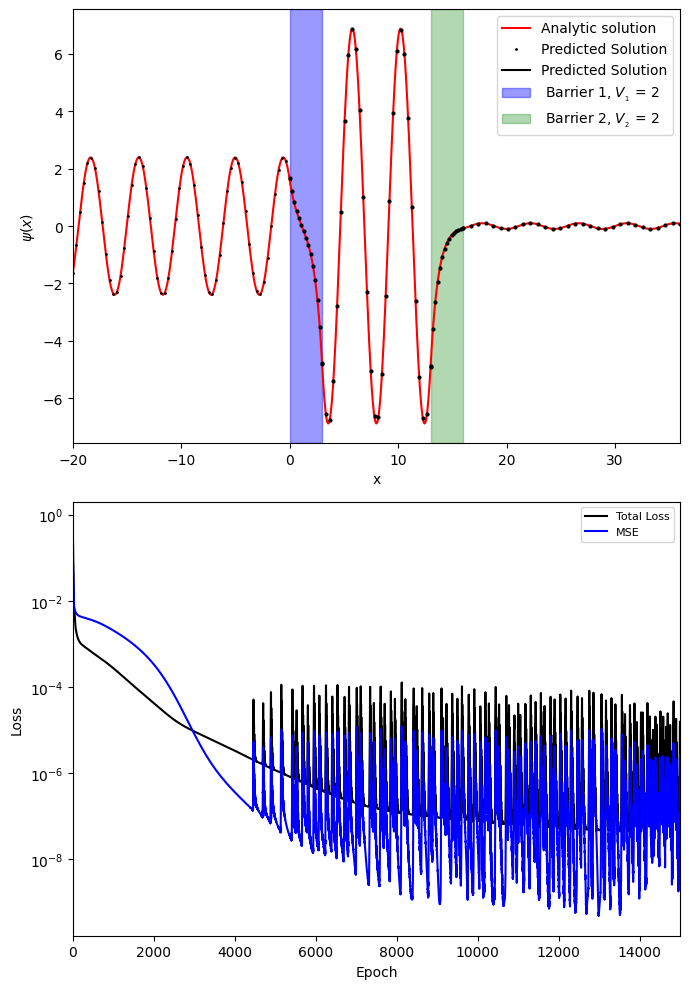

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


Energy = 1   # energia da partícula
V1 = 2       # potencial da primeira barreira
V2 = 2       # potencial da segunda barreira
h = 1        # constante de Planck
m = 1        # massa da partícula
x = -20
x_0 = 0

x_beta =  3                        # comprimento da primeira barreira
x_theta = 3                          # comprimento da segunda barreira
x_entre_bar = 10                     # comprimento  entre as barreiras
x_alpha = x_entre_bar + x_beta       # extremidade esquerda d,,,,a primeira barreira
x_gama = x_alpha + x_theta           # extremidade direita da primeira barreira
x_L = x_gama + 20


# números de ondas das regiões
k1 =  np.sqrt(2 * m * Energy) /h
k2 =  np.sqrt(2 * m * (V1 - Energy)) / h
k3 =  np.sqrt(2 * m * (V2 - Energy)) / h


#np.exp()
#amplitudes da onda
I = 0.1
H = ( np.exp(x_gama * k3) / (2 * k3) ) * (I *np.exp(1j*k1*x_gama )*(k3 - (1j*k1)) )
G = ( np.exp(-x_gama * k3) / (2 * k3) ) * (I *np.exp(1j * k1 * x_gama )* (k3 + 1j * k1))
F = 0.5* ( 1j*np.exp(1j*x_alpha*k1)/k1 ) * (G * np.exp(x_alpha * k3) * (k3 - 1j*k1) - H * np.exp(-x_alpha * k3) * (k3 + 1j*k1)  )
E = -0.5*(1j*np.exp(-1j*x_alpha * k1) /k1 ) * (G * np.exp(x_alpha * k3) * (k3 + 1j*k1) + H * np.exp(-x_alpha * k3) * (1j*k1 - k3) )
D = (np.exp(x_beta * k2)/(2*k2)) * (F * np.exp(-1j*x_beta * k1) * (1j * k1 + k2) - E * np.exp(1j*x_beta * k1)*(1j*k1 - k2))
C = (np.exp(-x_beta * k2)/(2*k2)) * (F * np.exp(-1j*x_beta * k1) * (k2 -1j*k1) + E * np.exp(1j*x_beta * k1)*(1j*k1 + k2))
B = (-1j /(2*k1)) * (D * (k2 + (1j*k1) ) - C * (k2 -1j*k1) )
A = (-1j /(2*k1)) * (C * (k2 + (1j*k1) ) - D * (k2 -1j*k1) )


#treinamento na IA

class OdeSecond(nn.Module):
    def __init__(self):
        super(OdeSecond, self).__init__()
        self.dense1 = nn.Linear(1, 32)
        self.dense2 = nn.Linear(32, 32)
        self.dense3 = nn.Linear(32, 1)


    def forward(self, x):
        x = torch.sin(self.dense1(x))
        x = torch.sin(self.dense2(x))
        return self.dense3(x)


# Funções de treinamento  x_beta <= X <= x_alpha  psi(x) =  E * np.exp(1j * k1 * x) + F * np.exp(-1j * k1 * x)
def train_step_zero(model, optimizer, loss_fn, x_train, y_train):
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    optimizer.zero_grad()

    x0 = torch.tensor([ x ], dtype=torch.float32, requires_grad=True)
    y0_exact = torch.tensor([  A * np.exp(1j * k1 * x) + B * np.exp(-1j * k1 * x)], dtype=torch.float32)
    dy_dx0_exact = torch.tensor([ A * 1j * k1 * np.exp(1j * k1 * x) - B * 1j * k1 *  np.exp(-1j * k1 * x)  ], dtype=torch.float32)

    xL = torch.tensor([ x_0 ], dtype=torch.float32, requires_grad=True)
    yL_exact = torch.tensor([ A + B ], dtype=torch.float32)                # contorno x = L (observe que tanto faz usar psi1(x) ou ps2(x) em x= L = 0

    y0_NN = model(x0)
    dy_dx0_NN = torch.autograd.grad(y0_NN.sum(), x0, create_graph=True)[0]
    yL_NN = model(xL)

    y_NN = model(x_train_tensor)
    dy_dx_NN = torch.autograd.grad(y_NN.sum(), x_train_tensor, create_graph=True)[0]
    d2y_dx2_NN = torch.autograd.grad(dy_dx_NN.sum(), x_train_tensor, create_graph=True)[0]

    loss = (
        loss_fn(y0_NN, y0_exact)
        + loss_fn(d2y_dx2_NN, -y_NN * (k1**2))
        + loss_fn(dy_dx0_NN, dy_dx0_exact)
        + loss_fn(yL_NN, yL_exact))

    loss.backward()
    optimizer.step()

    mse = nn.MSELoss()(y_NN, y_train_tensor)
    return loss.item(), mse.item()

def train_step_bar1(model, optimizer, loss_fn, x_train, y_train):
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    optimizer.zero_grad()

    x0 = torch.tensor([ x_0 ], dtype=torch.float32, requires_grad=True)
    y0_exact = torch.tensor([  C + D  ], dtype=torch.float32)
    dy_dx0_exact = torch.tensor([ (C - D)*k2  ], dtype=torch.float32)

    xL = torch.tensor([  x_beta  ], dtype=torch.float32, requires_grad=True)
    yL_exact = torch.tensor([ C * np.exp(k2 * x_beta) + D * np.exp(-k2*x_beta) ], dtype=torch.float32)

    y0_NN = model(x0)
    dy_dx0_NN = torch.autograd.grad(y0_NN.sum(), x0, create_graph=True)[0]
    yL_NN = model(xL)

    y_NN = model(x_train_tensor)
    dy_dx_NN = torch.autograd.grad(y_NN.sum(), x_train_tensor, create_graph=True)[0]
    d2y_dx2_NN = torch.autograd.grad(dy_dx_NN.sum(), x_train_tensor, create_graph=True)[0]

    loss = (
          loss_fn(y0_NN, y0_exact)
        + loss_fn(d2y_dx2_NN, y_NN*(k2**2))
        + loss_fn(dy_dx0_NN, dy_dx0_exact)
        + loss_fn(yL_NN, yL_exact))

    loss.backward()
    optimizer.step()

    mse = nn.MSELoss()(y_NN, y_train_tensor)
    return loss.item(), mse.item()


def train_step_one(model, optimizer, loss_fn, x_train, y_train):
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    optimizer.zero_grad()

    x0 = torch.tensor([ x_beta ], dtype=torch.float32, requires_grad=True)
    y0_exact = torch.tensor([  E * np.exp(1j * k1 * x_beta) + F * np.exp(-1j * k1 * x_beta)  ], dtype=torch.float32)
    dy_dx0_exact = torch.tensor([   E * 1j* k1 * np.exp(1j * k1 * x_beta) - F * 1j* k1 * np.exp(-1j * k1 * x_beta)  ], dtype=torch.float32)

    xL = torch.tensor([ x_alpha ], dtype=torch.float32, requires_grad=True)
    yL_exact = torch.tensor([ E * np.exp(1j * k1 * x_alpha) + F * np.exp(-1j * k1 * x_alpha) ], dtype=torch.float32)

    y0_NN = model(x0)
    dy_dx0_NN = torch.autograd.grad(y0_NN.sum(), x0, create_graph=True)[0]
    yL_NN = model(xL)

    y_NN = model(x_train_tensor)
    dy_dx_NN = torch.autograd.grad(y_NN.sum(), x_train_tensor, create_graph=True)[0]
    d2y_dx2_NN = torch.autograd.grad(dy_dx_NN.sum(), x_train_tensor, create_graph=True)[0]

    loss = (
         loss_fn(y0_NN, y0_exact)
        + loss_fn(d2y_dx2_NN, -y_NN * (k1**2))
        + loss_fn(dy_dx0_NN, dy_dx0_exact)
        + loss_fn(yL_NN, yL_exact))

    loss.backward()
    optimizer.step()

    mse = nn.MSELoss()(y_NN, y_train_tensor)
    return loss.item(), mse.item()




def train_step_bar2(model, optimizer, loss_fn, x_train, y_train):
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    optimizer.zero_grad()

    x0 = torch.tensor([  x_alpha  ], dtype=torch.float32, requires_grad=True)
    y0_exact = torch.tensor([  G * np.exp(k3 * x_alpha) + H * np.exp(-k3 * x_alpha)  ], dtype=torch.float32)
    dy_dx0_exact = torch.tensor([  G * k3 * np.exp(k3 * x_alpha) - H * k3 *  np.exp(-k3 * x_alpha)   ], dtype=torch.float32)

    xL = torch.tensor([  x_gama ], dtype=torch.float32, requires_grad=True)
    yL_exact = torch.tensor([ G * np.exp(k3 * x_gama) + H * np.exp(-k3 * x_gama) ], dtype=torch.float32)

    y0_NN = model(x0)
    dy_dx0_NN = torch.autograd.grad(y0_NN.sum(), x0, create_graph=True)[0]
    yL_NN = model(xL)

    y_NN = model(x_train_tensor)
    dy_dx_NN = torch.autograd.grad(y_NN.sum(), x_train_tensor, create_graph=True)[0]
    d2y_dx2_NN = torch.autograd.grad(dy_dx_NN.sum(), x_train_tensor, create_graph=True)[0]

    loss = (
          loss_fn(y0_NN, y0_exact)
        + loss_fn(d2y_dx2_NN, y_NN * (k3**2))
        + loss_fn(dy_dx0_NN, dy_dx0_exact)
        + loss_fn(yL_NN, yL_exact))

    loss.backward()
    optimizer.step()

    mse = nn.MSELoss()(y_NN, y_train_tensor)
    return loss.item(), mse.item()

def train_step_three(model, optimizer, loss_fn, x_train, y_train):
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    optimizer.zero_grad()

    x0 = torch.tensor([ x_gama ], dtype=torch.float32, requires_grad=True)
    y0_exact = torch.tensor([  I * np.exp(1j * k1 * x_gama) ], dtype=torch.float32)
    dy_dx0_exact = torch.tensor([  I * 1j * k1 * np.exp(1j * k1 * x_gama)    ], dtype=torch.float32)

    xL = torch.tensor([ x_L ], dtype=torch.float32, requires_grad=True)
    yL_exact = torch.tensor([  I * np.exp(1j * k1 * x_L) ], dtype=torch.float32)                # contorno x = L (observe que tanto faz usar psi1(x) ou ps2(x) em x= L = 0

    y0_NN = model(x0)
    dy_dx0_NN = torch.autograd.grad(y0_NN.sum(), x0, create_graph=True)[0]
    yL_NN = model(xL)

    y_NN = model(x_train_tensor)
    dy_dx_NN = torch.autograd.grad(y_NN.sum(), x_train_tensor, create_graph=True)[0]
    d2y_dx2_NN = torch.autograd.grad(dy_dx_NN.sum(), x_train_tensor, create_graph=True)[0]

    loss = (
        loss_fn(y0_NN, y0_exact)
        + loss_fn(d2y_dx2_NN, -y_NN * (k1**2))
        + loss_fn(dy_dx0_NN, dy_dx0_exact)
        + loss_fn(yL_NN, yL_exact))

    loss.backward()
    optimizer.step()

    mse = nn.MSELoss()(y_NN, y_train_tensor)
    return loss.item(), mse.item()



# FALTA AQUI

# Função para plotar as soluções
def plot_combined_solution(model0, model_bar1, model1, model_bar2, model3, x_train0, y_train0, x_train_bar1,
                           y_train_bar1, x_train1, y_train1, x_train_bar2, y_train_bar2,   x_train3, y_train3,
                           loss_0,loss_bar1, loss_1, loss_bar2,  loss_3, mse):
    model0.eval()
    model_bar1.eval()
    model1.eval()
    model_bar2.eval()
    model3.eval()

    x_test_tensor_0 = torch.linspace(x, x_0, 60).unsqueeze(1)
    x_test_tensor_bar1 = torch.linspace(x_0, x_beta, 15).unsqueeze(1)
    x_test_tensor_1 = torch.linspace(x_beta, x_alpha, 30).unsqueeze(1)
    x_test_tensor_bar2 = torch.linspace(x_alpha, x_gama, 15).unsqueeze(1)
    x_test_tensor_3 = torch.linspace(x_gama, x_L, 30).unsqueeze(1)


    with torch.no_grad():
        y_pred_0 = model0(x_test_tensor_0).numpy()
        y_pred_bar1 = model_bar1(x_test_tensor_bar1 ).numpy()
        y_pred_1 = model1(x_test_tensor_1).numpy()
        y_pred_bar2 = model_bar2( x_test_tensor_bar2).numpy()
        y_pred_3 = model3(x_test_tensor_3).numpy()



    fig, ax = plt.subplots(2, 1, figsize=(7, 10))
    plt.rcParams['figure.dpi'] = 200

    alpha = 0.4
    ax[0].plot(x_train0, y_train0  , color='red', markersize=7, label='Analytic solution')
    ax[0].plot(x_test_tensor_0.numpy(), y_pred_0, '.', alpha, markersize=2, color='black', label = 'Predicted Solution')
    ax[0].set_xlim(min(x_train0), max(x_train3))

    ax[0].plot( x_train_bar1, y_train_bar1  ,markersize=7, color='red')
    ax[0].plot(x_test_tensor_bar1.numpy(), y_pred_bar1, 'o', alpha, markersize=2, color='black')

    ax[0].plot(x_train1, y_train1, markersize=7, color='red')
    ax[0].plot(x_test_tensor_1.numpy(),  y_pred_1 , 'o',alpha, markersize=2, color='black')

    ax[0].plot( x_train_bar2, y_train_bar2  ,markersize=7, color='red')
    ax[0].plot(x_test_tensor_bar2.numpy(), y_pred_bar2, 'o', alpha, markersize=2, color='black')

    ax[0].plot(x_train3, y_train3 ,markersize=7, color='red')
    ax[0].plot(x_test_tensor_3.numpy(),  y_pred_3, 'o', alpha, markersize=2, color='black')

    #ax[0].axhline(0, color='black',linewidth=0.6)
    #ax[0].axhline(Energy, color='red',linewidth=0.6)
    ax[0].axvspan(0, x_beta, color='blue', alpha=0.4, label= r' Barrier 1, $V_{_1}$ = 'f'{V1}')
    ax[0].axvspan(x_alpha, x_gama, color='green', alpha=0.3, label= r' Barrier 2, $V_{_2}$ = 'f'{V2}')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel(r'$\psi(x)$')
    ax[0].legend()

    # Subplot 2: Gráfico dos valores de perda

    #ax[1].plot(loss_0, label='Região I', color='black')
    #ax[1].plot(loss_bar1, label='Barreira I', color='green')
    #ax[1].plot(loss_1, label='Região I', color='orange')
    #ax[1].plot(loss_bar2, label='Barreira II', color='blue')
    ax[1].plot(loss_3, label='Total Loss', color='black')
    ax[1].plot(mse, label="MSE", color="Blue")
    ax[1].set_yscale('log')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend(loc='best', fontsize=8)
    ax[1].set_xlim(0, len(loss_3))

    plt.tight_layout()
    plt.show()

# Execução do código
if __name__ == "__main__":

    # Treinamento para antes da primeira barreira
    epochs = 15000
    x_train0 = np.linspace(x, x_0, 200)[:, np.newaxis]
    y_train0 = A * np.exp(1j * k1 * x_train0) + B * np.exp(-1j * k1 * x_train0)
    model0 = OdeSecond()
    optimizer0 = optim.Adam(model0.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()


    loss_values_0 = []
    for epoch in range(epochs):
        loss, mse = train_step_zero(model0, optimizer0, loss_fn, x_train0, y_train0)
        loss_values_0.append(loss)

    #--------------------------------------------------------------------------------------------
    #--------------------------------------------------------------------------------------------

    # Treinamento para a primeira barreira

    x_train_bar1 =  np.linspace(x_0, x_beta, 200)[:, np.newaxis]
    y_train_bar1 =  C  * np.exp(k2 * x_train_bar1) + D * np.exp(-k2 * x_train_bar1)
    model_bar1 = OdeSecond()
    optimizer_bar1 = optim.Adam(model_bar1.parameters(), lr=0.01)
    loss_values_bar1 = []

    for epoch in range(epochs):
        loss, mse = train_step_bar1(model_bar1,  optimizer_bar1, loss_fn, x_train_bar1, y_train_bar1)
        loss_values_bar1.append(loss)

    #--------------------------------------------------------------------------------------------
    #--------------------------------------------------------------------------------------------

    # Treinamento para entre as barreiras

    x_train1 = np.linspace(x_beta, x_alpha, 200)[:, np.newaxis]
    y_train1 = E * np.exp(1j * k1 * x_train1) + F * np.exp(-1j * k1 * x_train1)
    model1 = OdeSecond()
    optimizer1 = optim.Adam(model1.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()

    loss_values_1 = []
    for epoch in range(epochs):
        loss, mse = train_step_one(model1, optimizer1, loss_fn, x_train1, y_train1)
        loss_values_1.append(loss)

    #--------------------------------------------------------------------------------------------
    #--------------------------------------------------------------------------------------------

    # Treinamento para a segunda barreira

    x_train_bar2 =  np.linspace(x_alpha, x_gama, 200)[:, np.newaxis]
    y_train_bar2 =  G  * np.exp(k3 * x_train_bar2) + H * np.exp(-k3  * x_train_bar2)
    model_bar2 = OdeSecond()
    optimizer_bar2 = optim.Adam(model_bar2.parameters(), lr=0.01)
    loss_values_bar2 = []

    for epoch in range(epochs):
        loss, mse = train_step_bar2(model_bar2, optimizer_bar2, loss_fn, x_train_bar2, y_train_bar2)
        loss_values_bar2.append(loss)

    #--------------------------------------------------------------------------------------------
    #--------------------------------------------------------------------------------------------

    # Treinamento para após a barreira
    x_train3 = np.linspace(x_gama, x_L, 200)[:, np.newaxis]
    y_train3 = I * np.exp(1j * k1 * x_train3)
    model3 = OdeSecond()
    optimizer3 = optim.Adam(model3.parameters(), lr=0.001)
    loss_values_3 = []
    mse_values_3 = []


    for epoch in range(epochs):
        loss, mse = train_step_three(model3, optimizer3, loss_fn, x_train3, y_train3)
        loss_values_3.append(loss)
        mse_values_3.append(mse)





    # Plotando ambas as soluções e os valores de perda
    plot_combined_solution(model0, model_bar1, model1, model_bar2, model3, x_train0, y_train0, x_train_bar1, y_train_bar1, x_train1, y_train1, x_train_bar2, y_train_bar2,   x_train3, y_train3,  loss_values_0,
                           loss_values_bar1, loss_values_1,   loss_values_bar2,  loss_values_3,mse_values_3 )
